# COMP3221 - Distributed Systems

## Week 6 - Tutorial - Federated Learning

**Objectives:**

* To understand the basics of federated learning algorithm (FedAvg)
* Using Pytorch to implement a federated learning system

**Instructions:**
* Exercises tend to be completed by **Python 3** programming language.
* You can either use IPython notebook or just python files to finish the exercises.
* To install IPython notebooks and Python 3, you can:
   * Use IPython 3 (Jupyter) notebook installed on your computer: http://jupyter.org/install (you need to have Python installed first: https://docs.python.org/3/using/index.html )
   * Use Web-based IPython notebooks such as Google Colaboratory: https://colab.research.google.com/   
* Using the IPython notebook:
  * If you are using Jupyter intalled on your computer, Go to *File -> Open*. Drag and drop the "*.ipynb*" file to the home interface and click upload.
  * If you are using Google Colaboratory, Click *File -> Upload notebook*, and upload the "*.ipynb*" file.
  * To run the code cells you can press *Ctrl-Enter* or hit the *Play* button at the top.
* Using python files:
  * We recommend using Visual Studio Code as IDE: https://code.visualstudio.com/
  
* Please complete all exercises marked with **TODO**.
* Make sure to save your files when you are done with the exercises, so you can show your tutor next week.

In this tutorial we will use **pytorch** to implement federated learning.

In [ ]:
!pip install torch torchvision torchaudio

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

import os
import json
import copy
import random
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

### 1.1 Generate Synthetic Dataset for Linear Regression

We start by developing a function to generate a synthetic Linear Regression dataset for each client, using a linear equation and incorporating unique noise variations for each client.

In [2]:
def get_data(client_id):

    np.random.seed(client_id)
    n_samples = np.random.randint(800, 1000)
    X = np.random.rand(n_samples)
    y = 4 + 3 * X + (client_id/10.0)*np.random.randn(n_samples)

    # Split the original dataset into a training set and a test set
    X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size = 0.2, random_state=client_id)

    # Cast variables to torch type
    X_train = torch.Tensor(X_train).view(-1,1).type(torch.float32)
    y_train = torch.Tensor(y_train).type(torch.float32)
    X_test = torch.Tensor(X_test).view(-1,1).type(torch.float32)
    y_test = torch.Tensor(y_test).type(torch.float32)

    # Training Size, Test Size
    train_samples, test_samples = len(y_train), len(y_test)

    return X_train, y_train, X_test, y_test, train_samples, test_samples

**Preview some data examples from client 1**

In [ ]:
client_id = 1
X_train, y_train, X_test, y_test, train_samples, test_samples= get_data(client_id)

: 

In [4]:
train_samples, test_samples

(669, 168)

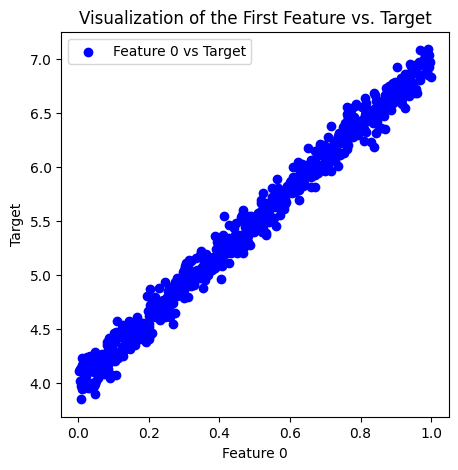

In [5]:
# Plotting the first feature against the target to visualize the dataset
plt.figure(figsize=(5, 5))
plt.scatter(X_train, y_train, color='blue', label='Feature 0 vs Target')
plt.title('Visualization of the First Feature vs. Target')
plt.xlabel('Feature 0')
plt.ylabel('Target')
plt.legend()
plt.show()

**Preview some data examples from client 3**

In [6]:
client_id = 3
X_train, y_train, X_test, y_test, train_samples, test_samples= get_data(client_id)

In [7]:
train_samples, test_samples

(724, 182)

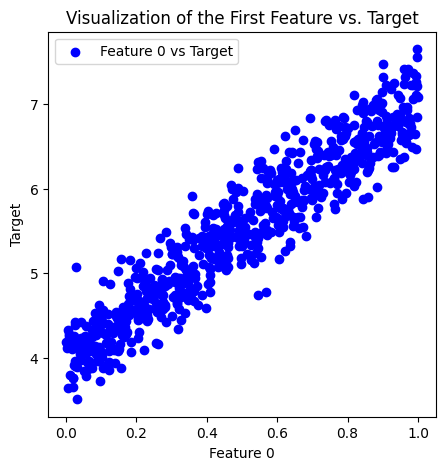

In [8]:
# Plotting the first feature against the target to visualize the dataset
plt.figure(figsize=(5, 5))
plt.scatter(X_train, y_train, color='blue', label='Feature 0 vs Target')
plt.title('Visualization of the First Feature vs. Target')
plt.xlabel('Feature 0')
plt.ylabel('Target')
plt.legend()
plt.show()

### 1.2 Machine Learning model

Next, we define a linear regression model using the well-known Pytorch library. The definition of the model is defined as follows:

In [9]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size = 1):
        super(LinearRegressionModel, self).__init__()
        # Create a linear transformation to the incoming data
        self.linear = nn.Linear(input_size, 1)

    # Define how the model is going to be run, from input to output
    def forward(self, x):
        # Apply linear transformation
        output = self.linear(x)
        return output.reshape(-1)

### 1.3 Federated learning algorithms

<img src="https://raw.githubusercontent.com/longtanle/distributed_systems_tutorials/main/w6/Algorithms.png" width=600>

### 1.4 Define Client

Each client has 3 main functions.
- **set_parameters**: receive a global model from the server, replace its local model with the global model.
- **train**: using the new global model to continue training to obtain a new local model.
- **test**: evaluate the global model receiving from the server.

In [10]:
class UserAVG():
    def __init__(self, client_id, model, learning_rate, batch_size):

        self.X_train, self.y_train, self.X_test, self.y_test, self.train_samples, self.test_samples = get_data(client_id)

        self.train_data = [(x, y) for x, y in zip(self.X_train, self.y_train)]
        self.test_data = [(x, y) for x, y in zip(self.X_test, self.y_test)]

        # Define dataloader for iterable sample over a dataset
        self.trainloader = DataLoader(self.train_data, batch_size = batch_size)
        self.testloader = DataLoader(self.test_data, batch_size = self.test_samples)

        # Define the Mean Square Error Loss
        self.loss = nn.MSELoss()

        self.model = copy.deepcopy(model)

        self.id = client_id

        # Define the Gradient Descent optimizer
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=learning_rate)

    def set_parameters(self, model):
        for old_param, new_param in zip(self.model.parameters(), model.parameters()):
            old_param.data = new_param.data.clone()

    def train(self, epochs):
        LOSS = 0
        self.model.train()
        for epoch in range(1, epochs + 1):
            self.model.train()
            for batch_idx, (X, y) in enumerate(self.trainloader):
                self.optimizer.zero_grad()
                output = self.model(X)
                loss = self.loss(output, y)
                loss.backward()
                self.optimizer.step()
        return loss.data

    def test(self):
        self.model.eval()
        mse = 0
        for x, y in self.testloader:
            y_pred = self.model(x)
            # Calculate evaluation metrics
            mse += self.loss(y_pred, y)
            print(str(self.id) + ", MSE of client ",self.id, " is: ", mse)
        return mse

### 1.4 Define Server

The server has 3 main functions:
- **send_parameters**: broadcast the global model to all clients
- **aggregate_parameters**: aggregate new global model from local models of all clients.
- **evaluate**: evaluate the global model across all clients

In [11]:
def send_parameters(server_model, users):
    for user in users:
        user.set_parameters(server_model)

def aggregate_parameters(server_model, users, total_train_samples):
    # Clear global model before aggregation
    for param in server_model.parameters():
        param.data = torch.zeros_like(param.data)

    for user in users:
        for server_param, user_param in zip(server_model.parameters(), user.model.parameters()):
            server_param.data = server_param.data + user_param.data.clone() * user.train_samples / total_train_samples
    return server_model

def evaluate(users):
    total_mse = 0
    for user in users:
        total_mse += user.test()
    return total_mse/len(users)

### 1.5 Create a federated learning network with 5 clients

In [12]:
# Init parameters
num_user = 5
users = []
server_model = LinearRegressionModel()
batch_size = 64
learning_rate = 0.01
num_glob_iters = 100 # No. of global rounds

# TODO:  Create a federate learning network with 5 clients and append it to users list.
total_train_samples = 0
for i in range(1,num_user+1):
    user = UserAVG(i, server_model, learning_rate, batch_size)
    users.append(user)
    total_train_samples += user.train_samples
    send_parameters(server_model, users)

In [13]:
# Runing FedAvg
train_mse = []
test_mse = []

for glob_iter in range(num_glob_iters):

    # TODO: Broadcast global model to all clients
    send_parameters(server_model,users)

    # Evaluate the global model across all clients
    avg_mse = evaluate(users)
    test_mse.append(avg_mse.item())
    print("Global Round:", glob_iter + 1, "Average MSE across all clients : ", avg_mse)

    # Each client keeps training process to  obtain new local model from the global model
    avgLoss = 0
    for user in users:
        # Each user trains the local model for 2 epochs
        avgLoss += user.train(2)
    # Above process training all clients and all client paricipate to server, how can we just select subset of user for aggregation
    train_mse.append(avgLoss)

    # TODO:  Aggregate all clients model to obtain new global model
    aggregate_parameters(server_model, users, total_train_samples)

1, MSE of client  1  is:  tensor(26.3523, grad_fn=<AddBackward0>)
2, MSE of client  2  is:  tensor(25.6370, grad_fn=<AddBackward0>)
3, MSE of client  3  is:  tensor(26.4240, grad_fn=<AddBackward0>)
4, MSE of client  4  is:  tensor(25.4382, grad_fn=<AddBackward0>)
5, MSE of client  5  is:  tensor(26.0938, grad_fn=<AddBackward0>)
Global Round: 1 Average MSE across all clients :  tensor(25.9891, grad_fn=<DivBackward0>)
1, MSE of client  1  is:  tensor(7.8037, grad_fn=<AddBackward0>)
2, MSE of client  2  is:  tensor(7.5695, grad_fn=<AddBackward0>)
3, MSE of client  3  is:  tensor(7.8049, grad_fn=<AddBackward0>)
4, MSE of client  4  is:  tensor(7.5803, grad_fn=<AddBackward0>)
5, MSE of client  5  is:  tensor(7.8945, grad_fn=<AddBackward0>)
Global Round: 2 Average MSE across all clients :  tensor(7.7306, grad_fn=<DivBackward0>)
1, MSE of client  1  is:  tensor(2.3894, grad_fn=<AddBackward0>)
2, MSE of client  2  is:  tensor(2.3173, grad_fn=<AddBackward0>)
3, MSE of client  3  is:  tensor(2.3

Plot average training loss across all clients during training

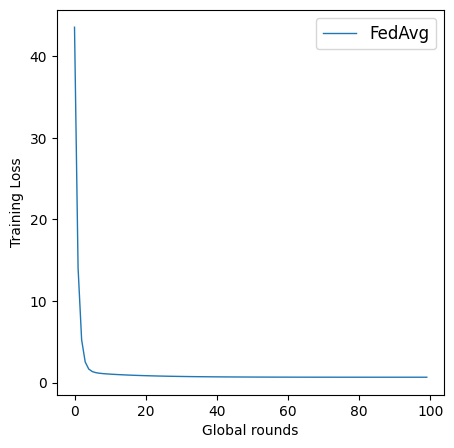

In [17]:
plt.figure(1,figsize=(5, 5))
plt.plot(train_mse, label="FedAvg", linewidth  = 1)
plt.legend(loc='upper right', prop={'size': 12}, ncol=2)
plt.ylabel('Training Loss')
plt.xlabel('Global rounds')
plt.show()

Plot average testing accuracy across all clients during training

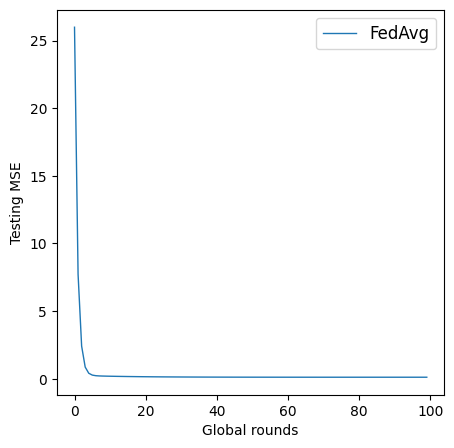

In [18]:
plt.figure(1,figsize=(5, 5))
plt.plot(test_mse, label="FedAvg", linewidth  = 1)
#plt.ylim([0.9,  0.99])
plt.legend(loc='upper right', prop={'size': 12}, ncol=2)
plt.ylabel('Testing MSE')
plt.xlabel('Global rounds')
plt.show()

At the end, we can retrieve the weight and bias of the global linear model

In [19]:
weights = server_model.linear.weight.data
bias = server_model.linear.bias.data

print("Weights:", weights)
print("Bias:", bias)

Weights: tensor([[2.9651]])
Bias: tensor([4.0198])
